In [1]:
!pip install openmim
!mim install mmengine "mmcv>=2.0.1" "mmdet>=3.1.0" "mmpose>=1.1.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.1.0/index.html


In [19]:
from mmpose.apis import MMPoseInferencer
import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from io import BytesIO
import cv2
from collections import defaultdict


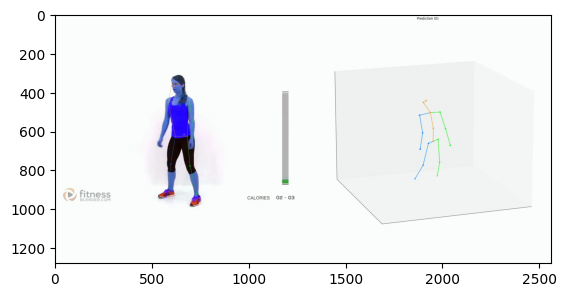

(1, 1280, 2560, 3)
(602, 1200, 3)


In [3]:
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def image_to_numpy_array(img):
    return np.array(img)

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames

image_url = 'https://hips.hearstapps.com/hmg-prod/images/squat-jump-squat-178-1653334247.jpg?crop=0.859xw:0.646xh;0.0481xw,0.342xh&resize=1200:*'
#image_url = 'https://i.redd.it/yzi7qrdyc5r41.jpg'
image = load_image_from_url(image_url)
image_array = image_to_numpy_array(image)

#plt.imshow(image_array)
#plt.show()

video_path = 'squat_video.mp4'
video_frames = load_video_frames(video_path)
video_arrays = np.array(video_frames)

plt.imshow(video_arrays[0])
plt.show()

print(video_arrays.shape)
print(image_array.shape)

In [ ]:
inferencer = MMPoseInferencer(pose3d='human3d')
result_generator = inferencer('squat_video.mp4', vis_out_dir='./output')
result = next(result_generator)

kpts = []

while result:
  kpts.append(np.array(result['predictions'][0][0]['keypoints']))
  result = next(result_generator)


print(result.keys())
print(kpts.shape)
print(kpts)

In [6]:
kpts

[array([[-0.        ,  0.        ,  0.7266199 ],
        [ 0.08496899,  0.07623506,  0.73009497],
        [ 0.1296643 ,  0.02053465,  0.37049171],
        [ 0.14246826, -0.23066007,  0.05688429],
        [-0.08793604, -0.07076912,  0.72398686],
        [-0.11305346, -0.0838233 ,  0.34757206],
        [-0.19509961, -0.38630408,  0.        ],
        [ 0.00859595,  0.02939764,  0.9427709 ],
        [ 0.02576392, -0.01797628,  1.1783787 ],
        [ 0.08231006, -0.10223446,  1.31977022],
        [ 0.07401685, -0.0297546 ,  1.3683877 ],
        [-0.1125896 , -0.07496649,  1.15410125],
        [-0.14180273,  0.03338488,  0.92064178],
        [-0.13720971,  0.19928019,  0.71285439],
        [ 0.1589248 , -0.01467296,  1.15419936],
        [ 0.17269751,  0.12630458,  0.92370868],
        [ 0.23818921,  0.22684981,  0.71127176]]),
 array([[-0.        ,  0.        ,  0.72841018],
        [ 0.08352149,  0.08182682,  0.73374355],
        [ 0.14129223,  0.01342233,  0.37526053],
        [ 0.146982

In [47]:
import json

with open('kpts.json', 'w') as f:
  f.write(json.dumps([x.tolist() for x in kpts],  indent=4))

In [41]:
kpt_dict = {0: 'hips',
            1: 'righthip',
            2: 'knee_right',
            3: 'feet_right',
            4: 'lefthip',
            5: 'knee_left',
            6: 'feet_left',
            7: 'spine_middle',
            8: 'spine_upper',
            9: 'neck',
            10: 'head_high',
            11: 'shoulder_left',
            12: 'elbow_left',
            13: 'hand_left',
            14: 'shoulder_right',
            15: 'elbow_right',
            16: 'hand_right'}

# Reverse the dictionary
reversed_kpt_dict = {value: key for key, value in kpt_dict.items()}

# Print the reversed dictionary
print(reversed_kpt_dict)

{'hips': 0, 'righthip': 1, 'knee_right': 2, 'feet_right': 3, 'lefthip': 4, 'knee_left': 5, 'feet_left': 6, 'spine_middle': 7, 'spine_upper': 8, 'neck': 9, 'head_high': 10, 'shoulder_left': 11, 'elbow_left': 12, 'hand_left': 13, 'shoulder_right': 14, 'elbow_right': 15, 'hand_right': 16}


In [38]:

def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793

        https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)

    radians_angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    degrees_angle = np.degrees(radians_angle)

    # Ensure the angle is between 0 and 360 degrees
    return (degrees_angle + 360) % 360

def Get_R(A,B):
    uA = A/np.sqrt(np.sum(np.square(A)))
    uB = B/np.sqrt(np.sum(np.square(B)))

    cos_t = np.sum(uA * uB)
    sin_t = np.sqrt(np.sum(np.square(np.cross(uA,uB)))) #magnitude

    u = uA
    v = uB - np.sum(uA * uB)*uA
    v = v/np.sqrt(np.sum(np.square(v)))
    w = np.cross(uA, uB)
    w = w/np.sqrt(np.sum(np.square(w)))

    C = np.array([u, v, w])
    R_uvw = np.array([[cos_t, -sin_t, 0],
                      [sin_t, cos_t, 0],
                      [0, 0, 1]])

    R = C.T @ R_uvw @ C
    return R

def Decompose_R_ZXY(R):
    thetaz = np.arctan2(-R[0,1], R[1,1])
    thetay = np.arctan2(-R[2,0], R[2,2])
    thetax = np.arctan2(R[2,1], np.sqrt(R[2,0]**2 + R[2,2]**2))

    return (360 + np.degrees(thetaz)) % 360, (360 + np.degrees(thetay)) % 360, (360 + np.degrees(thetax)) % 360

joints = defaultdict(list)

for kpt in kpts:
    a = kpt[4]
    b = kpt[5]
    c = kpt[6]

    ba = a - b
    bc = c - b

    R1 = Get_R(ba, bc)
    z1, y1, x1 = Decompose_R_ZXY(R1)
    joints['knee_left_x'].append(x1)
    joints['knee_left_y'].append(y1)
    joints['knee_left_z'].append(z1)

    a = kpt[1]
    b = kpt[2]
    c = kpt[3]

    ba = a - b
    bc = c - b

    R1 = Get_R(ba, bc)
    z1, y1, x1 = Decompose_R_ZXY(R1)
    joints['knee_right_x'].append(x1)
    joints['knee_right_y'].append(y1)
    joints['knee_right_z'].append(z1)


In [42]:
def get_hips_position_and_rotation(frame_pos, root_joint = 'hips', root_define_joints = ['lefthip', 'neck']):
    root_joint = reversed_kpt_dict[root_joint]
    root_define_joints = [reversed_kpt_dict[x] for x in root_define_joints]

    root_position = frame_pos[root_joint]

    root_u = frame_pos[root_define_joints[0]] - frame_pos[root_joint]
    root_u = root_u/np.sqrt(np.sum(np.square(root_u)))

    root_v = frame_pos[root_define_joints[1]] - frame_pos[root_joint]
    root_v = root_v/np.sqrt(np.sum(np.square(root_v)))

    root_w = np.cross(root_u, root_v)

    C = np.array([root_u, root_v, root_w]).T

    thetaz,thetay, thetax = Decompose_R_ZXY(C)
    root_rotation = np.array([thetaz, thetax, thetay])

    return root_position, root_rotation

In [43]:
get_hips_position_and_rotation(kpts[0])

(array([-0.       ,  0.       ,  0.7266199]),
 array([218.83791344,  77.45584595,   6.16226741]))

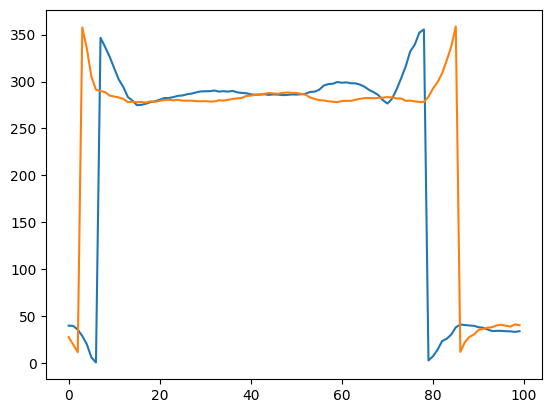

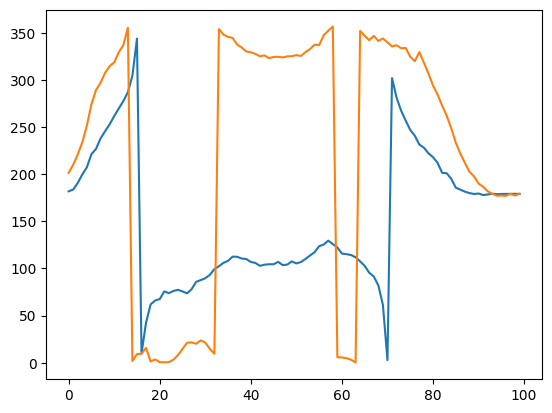

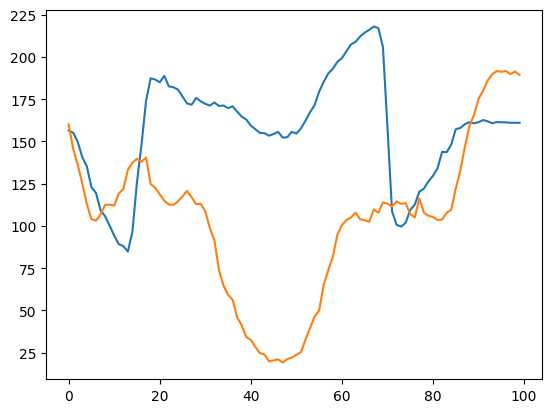

In [39]:
plt.plot(joints['knee_left_x'])
plt.plot(joints['knee_right_x'])
plt.show()

plt.plot(joints['knee_left_y'])
plt.plot(joints['knee_right_y'])
plt.show()

plt.plot(joints['knee_left_z'])
plt.plot(joints['knee_right_z'])
plt.show()

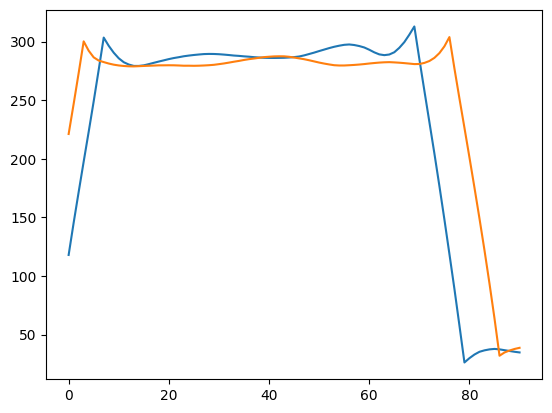

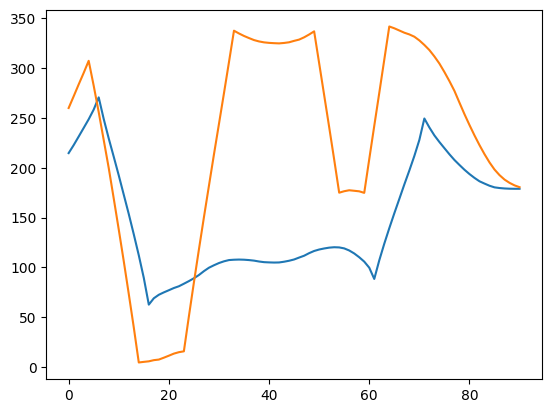

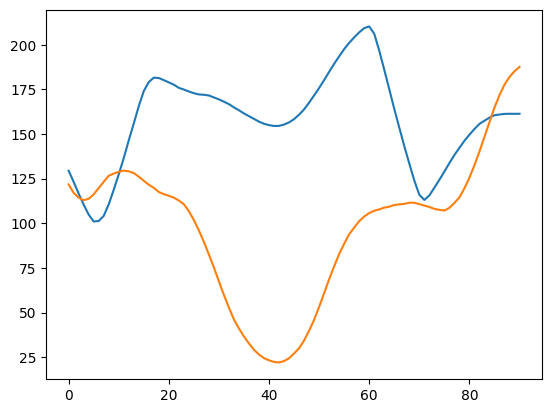

In [40]:
def simple_moving_average(data, window_size):
    if window_size <= 0:
        raise ValueError("Window size must be a positive integer.")

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)

    return moving_averages

window_size = 10

plt.plot(simple_moving_average(joints['knee_left_x'], window_size))
plt.plot(simple_moving_average(joints['knee_right_x'], window_size))
plt.show()

plt.plot(simple_moving_average(joints['knee_left_y'], window_size))
plt.plot(simple_moving_average(joints['knee_right_y'], window_size))
plt.show()

plt.plot(simple_moving_average(joints['knee_left_z'], window_size))
plt.plot(simple_moving_average(joints['knee_right_z'], window_size))
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for k in kpt:
    x, y, z = k
    ax.scatter(x, y, z, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(10, 30, 0)

plt.show()